# 🔐 **Análisis Exploratorio de Datos - Dataset RBA (Risk-Based Authentication)**
## 🧩 **Resumen Ejecutivo**

**Módulo**: Análisis Exploratorio de Datos para Detección de Accesos Sospechosos (Account Takeover)

**Fuente de datos**: `rba_balanced.csv` (Dataset balanceado del RBA original)

**Dataset original**: 31,269,264 logins del servicio SSO en Noruega (DAS Group - KIT)

**Dataset balanceado**: 141,141 registros (39 MB)
- **141 casos de Account Takeover** (TODOS los del dataset original)
- **141,000 casos normales** (muestreados aleatoriamente)
- **Ratio 1:1000** (Normal:ATO) - Balanceado y entrenable

**Periodo temporal**: Febrero 2020 - Febrero 2021 (12 meses)

## 🧪 **Introducción**

Este informe presenta un análisis exploratorio del **RBA Dataset Balanceado**, que contiene todos los casos de Account Takeover detectados en un año de operación de un servicio de Single Sign-On (SSO) con 3.3 millones de usuarios en Noruega.

**Contexto de Negocio**: Un **acceso sospechoso** es un evento de autenticación que, aunque puede ser técnicamente exitoso, presenta características **anómalas** o **inconsistentes** con el comportamiento esperado del usuario. Esto incluye:
- Cambios súbitos de geolocalización (Impossible Travel)
- Cambios de dispositivo/browser no habituales
- Acceso desde IPs maliciosas conocidas
- Patrones temporales inusuales

El objetivo es **identificar Account Takeover** (ATO): cuando un atacante usa credenciales robadas para acceder a una cuenta legítima.

## 📌 **Alcance del Análisis**

Este estudio analiza un dataset **balanceado estratégicamente**:

- **Cantidad de registros**: 141,141 logins
- **Casos de ATO**: 141 (100% del dataset original - no se pierde ninguno)
- **Casos normales**: 141,000 (muestreados del original)
- **Variables disponibles**: 16 atributos (IP, User ID, Timestamp, Browser, OS, Device, Country, etc.)
- **Periodo temporal**: Febrero 2020 - Febrero 2021
- **Clases**: Binaria (Is Account Takeover: True/False)
- **Balance**: Ratio 1:1000 (Normal:ATO) - Entrenable con SMOTE/class weights

**VENTAJAS DE ESTE DATASET**:
- ✅ **Todos los 141 casos de ATO** incluidos (sin pérdida de información)
- ✅ **Ratio 1:1000** manejable con técnicas de balance (SMOTE, class weights)
- ✅ **141K registros** suficientes para entrenar modelos robustos
- ✅ **Más balanceado** que el original (1:221,767 → 1:1,000)

## ❓ **Preguntas Clave de Negocio**

### **Distribución y Balance**
1. ¿Cuál es la distribución de Account Takeover en el dataset balanceado?
2. ¿Cuál es la tasa de login exitosos vs fallidos?

### **Patrones Geográficos**
3. ¿Desde qué países se originan más ataques de Account Takeover?
4. ¿Existen patrones de "Impossible Travel" (login desde ubicaciones imposibles en corto tiempo)?

### **Patrones de Dispositivos**
5. ¿Qué browsers/OS/devices son más utilizados en ataques?
6. ¿Los ataques muestran cambios frecuentes de dispositivo?

### **Patrones Temporales**
7. ¿A qué horas del día ocurren más ataques?
8. ¿Hay días de la semana con mayor actividad sospechosa?

### **Indicadores de Red**
9. ¿Cómo se comporta el Round-Trip Time (RTT) en logins normales vs ataques?
10. ¿Las IPs marcadas como "Attack IP" están correlacionadas con Account Takeover?

## 🧠 **Enfoque Metodológico**

### **1. Carga del Dataset Balanceado**
- Carga de 141K registros (39 MB)
- Validación de tipos de datos y valores nulos
- Análisis de distribución de clases

### **2. Análisis de Target Variable**
- Distribución de `Is Account Takeover` (141 casos reales)
- Distribución de `Login Successful`
- Relación entre ambas variables

### **3. Análisis de Features Categóricos**
- Browser Name and Version
- OS Name and Version
- Device Type (mobile/desktop/tablet/bot)
- Country, Region, City

### **4. Análisis de Features Numéricos**
- Round-Trip Time (RTT)
- ASN (Autonomous System Number)
- User ID distribution

### **5. Análisis Temporal**
- Distribución horaria de logins
- Distribución semanal
- Evolución temporal de ataques

### **6. Análisis de Comportamiento de Usuario**
- Intentos de login por usuario
- Tasa de éxito/fallo por usuario
- Cambios de IP/Browser/País por usuario

### **7. Identificación de Patrones Sospechosos**
- IPs con múltiples usuarios (Credential Stuffing)
- Usuarios con múltiples IPs (Account Sharing o ATO)
- Anomalías geográficas y temporales

In [1]:
# PASO 1: CONFIGURACIÓN INICIAL
# =====================================================

# Importación de librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from collections import Counter
from scipy import stats
import gc  # Garbage collector para manejo de memoria
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Colores para visualización
COLOR_NORMAL = '#2ecc71'  # Verde para logins normales
COLOR_ATTACK = '#e74c3c'  # Rojo para Account Takeover
COLOR_SUCCESS = '#3498db'  # Azul para login exitoso
COLOR_FAIL = '#f39c12'  # Naranja para login fallido

print("📦 Librerías importadas exitosamente")
print("🎨 Configuración de visualización lista")
print("\n" + "="*60)
print("   ANÁLISIS EXPLORATORIO - ACCESOS SOSPECHOSOS (RBA)")
print("="*60)

📦 Librerías importadas exitosamente
🎨 Configuración de visualización lista

   ANÁLISIS EXPLORATORIO - ACCESOS SOSPECHOSOS (RBA)


---
# FASE 1: CARGA Y EXPLORACIÓN INICIAL
---

In [2]:
# PASO 2: CARGA DEL DATASET BALANCEADO
# =====================================================

print("🔄 Cargando dataset RBA balanceado...")
print("-" * 60)
print("📂 Dataset: rba_balanced.csv")
print("   (Dataset balanceado con 141 casos de ATO + 141K normales)")
print()

# Ruta del archivo CSV balanceado
archivo_csv = "../processed_data/rba_balanced.csv"

# IMPORTANTE: Este dataset contiene:
# - TODOS los 141 casos de Account Takeover del dataset original (31M)
# - 141,000 casos normales muestreados aleatoriamente
# - Ratio 1:1000 (Normal:ATO) - Balanceado y entrenable

try:
    print(f"📊 Cargando {archivo_csv}...")
    df = pd.read_csv(archivo_csv)
    
    print(f"\n✅ Dataset cargado exitosamente")
    print(f"📊 Dimensiones: {df.shape[0]:,} filas x {df.shape[1]} columnas")
    print(f"📅 Fecha de análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💾 Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\n💡 VENTAJAS DE ESTE DATASET:")
    print("   • TODOS los 141 casos reales de ATO (no perdemos ninguno)")
    print("   • Ratio 1:1000 entrenable con SMOTE/class weights")
    print("   • 141K registros suficientes para modelado robusto")
    print("   • Más balanceado que original (1:221K → 1:1K)")
    
except FileNotFoundError:
    print(f"❌ ERROR: No se encontró el archivo {archivo_csv}")
    print("\n💡 SOLUCIÓN:")
    print("   1. Ejecuta: cd ../processed_data")
    print("   2. Ejecuta: python3 create_balanced_dataset.py")
    print("   3. Esto generará rba_balanced.csv con los 141 ATO")
    print("   4. Vuelve a ejecutar este notebook")
    
except Exception as e:
    print("❌ Error al cargar el archivo CSV")
    print(f"🛠️ Detalles del error: {e}")

🔄 Cargando dataset RBA balanceado...
------------------------------------------------------------
📂 Dataset: rba_balanced.csv
   (Dataset balanceado con 141 casos de ATO + 141K normales)

📊 Cargando ../processed_data/rba_balanced.csv...

✅ Dataset cargado exitosamente
📊 Dimensiones: 141,141 filas x 16 columnas
📅 Fecha de análisis: 2026-01-13 12:56:36
💾 Memoria utilizada: 94.60 MB

💡 VENTAJAS DE ESTE DATASET:
   • TODOS los 141 casos reales de ATO (no perdemos ninguno)
   • Ratio 1:1000 entrenable con SMOTE/class weights
   • 141K registros suficientes para modelado robusto
   • Más balanceado que original (1:221K → 1:1K)


In [3]:
# EXPLORACIÓN INICIAL DEL DATASET
# =====================================================

print("🔍 ESTRUCTURA Y COMPOSICIÓN DEL DATASET RBA")
print("=" * 100)

# Información básica del dataset
print("\n📋 INFORMACIÓN GENERAL:")
print(f"   • Número total de registros (muestra): {df.shape[0]:,}")
print(f"   • Número total de variables: {df.shape[1]}")
print(f"   • Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Mostrar las primeras filas
print("\n🔎 PRIMERAS 5 FILAS DEL DATASET:")
print("=" * 100)
display(df.head())

# Información de columnas
print("\n📊 INFORMACIÓN DE COLUMNAS:")
print("=" * 100)
df.info()

🔍 ESTRUCTURA Y COMPOSICIÓN DEL DATASET RBA

📋 INFORMACIÓN GENERAL:
   • Número total de registros (muestra): 141,141
   • Número total de variables: 16
   • Memoria utilizada: 94.60 MB

🔎 PRIMERAS 5 FILAS DEL DATASET:


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,12647791,2020-07-27 14:01:35.691,2525807992764531236,514.0,158.248.13.180,NO,Oslo County,Oslo,29695,Mozilla/5.0 (Linux; Android 6.9; SM-J500H/DS ...,Android 2.3.4,Android 6.9,mobile,True,False,False
1,20251964,2020-11-09 02:44:47.250,3654079718616468725,NaN,94.76.225.158,GB,-,-,29550,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Firefox 20.0,iOS 13.4,mobile,True,False,False
2,15110893,2020-08-31 17:29:36.660,-8432400846375905110,NaN,23.137.224.62,US,-,-,393398,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile 50.0.2661,Android 4.1,mobile,False,False,False
3,2196527,2020-03-03 13:50:15.746,4718795854946703718,NaN,209.236.123.216,US,-,-,393398,Mozilla/5.0 (Android 6.0.99; Tablet; https://...,Chrome Mobile 81.0.4044,Android 6.0.99,mobile,True,True,False
4,20951565,2020-11-17 04:18:54.107,-7070504222125438818,NaN,10.0.0.149,US,Colorado,Denver,398986,Mozilla/5.0 (Mobile; Windows Phone 8.1; Andro...,Chrome Mobile 81.0.4044.1949,Windows Phone 8.1,mobile,True,True,False



📊 INFORMACIÓN DE COLUMNAS:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141141 entries, 0 to 141140
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   index                     141141 non-null  int64  
 1   Login Timestamp           141141 non-null  object 
 2   User ID                   141141 non-null  int64  
 3   Round-Trip Time [ms]      6135 non-null    float64
 4   IP Address                141141 non-null  object 
 5   Country                   141141 non-null  object 
 6   Region                    140921 non-null  object 
 7   City                      141105 non-null  object 
 8   ASN                       141141 non-null  int64  
 9   User Agent String         141141 non-null  object 
 10  Browser Name and Version  141141 non-null  object 
 11  OS Name and Version       141141 non-null  object 
 12  Device Type               141133 non-null  object 
 13  Login Successful

In [4]:
# ANÁLISIS DE CALIDAD DE DATOS
# =====================================================

print("📊 ANÁLISIS DE CALIDAD DE DATOS")
print("=" * 100)

# Crear tabla de información
info_df = pd.DataFrame({
    'Variable': df.columns,
    'Tipo_Datos': df.dtypes,
    'Valores_No_Nulos': df.count(),
    'Valores_Nulos': df.isnull().sum(),
    'Porcentaje_Nulos': round((df.isnull().sum() / len(df)) * 100, 2),
    'Valores_Únicos': [df[col].nunique() for col in df.columns]
})

print("\n🏷️ RESUMEN DE VARIABLES:")
print("-" * 60)
display(info_df)

# Resumen estadístico
print("\n📈 RESUMEN ESTADÍSTICO:")
print(f"   • Total de valores nulos: {df.isnull().sum().sum():,}")
print(f"   • Porcentaje de completitud: {(1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")
print(f"   • Usuarios únicos en muestra: {df['User ID'].nunique():,}")
print(f"   • IPs únicas en muestra: {df['IP Address'].nunique():,}")
print(f"   • Países únicos: {df['Country'].nunique():,}")

📊 ANÁLISIS DE CALIDAD DE DATOS

🏷️ RESUMEN DE VARIABLES:
------------------------------------------------------------


,Variable,Tipo_Datos,Valores_No_Nulos,Valores_Nulos,Porcentaje_Nulos,Valores_Únicos
index,index,int64,141141,0,0.00,141141
Login Timestamp,Login Timestamp,object,141141,0,0.00,141141
User ID,User ID,int64,141141,0,0.00,76626
Round-Trip Time [ms],Round-Trip Time [ms],float64,6135,135006,95.65,1077
IP Address,IP Address,object,141141,0,0.00,84651
Country,Country,object,141141,0,0.00,167
Region,Region,object,140921,220,0.16,796
City,City,object,141105,36,0.03,4732
ASN,ASN,int64,141141,0,0.00,2151
User Agent String,User Agent String,object,141141,0,0.00,29076



📈 RESUMEN ESTADÍSTICO:
   • Total de valores nulos: 135,270
   • Porcentaje de completitud: 94.01%
   • Usuarios únicos en muestra: 76,626
   • IPs únicas en muestra: 84,651
   • Países únicos: 167


---
# FASE 2: ANÁLISIS DE TARGET VARIABLE
---

In [5]:
# ANÁLISIS DE DISTRIBUCIÓN DE TARGET: IS ACCOUNT TAKEOVER
# =====================================================

print("🎯 ANÁLISIS DE TARGET VARIABLE: IS ACCOUNT TAKEOVER")
print("=" * 100)

# Conteo de Account Takeover
ato_counts = df['Is Account Takeover'].value_counts()
ato_percentages = df['Is Account Takeover'].value_counts(normalize=True) * 100

print("\n📊 DISTRIBUCIÓN DE ACCOUNT TAKEOVER:")
print("-" * 60)
print(f"   • Logins Normales (False): {ato_counts.get(False, 0):,} ({ato_percentages.get(False, 0):.4f}%)")
print(f"   • Account Takeover (True): {ato_counts.get(True, 0):,} ({ato_percentages.get(True, 0):.4f}%)")
print(f"\n   • Ratio ATO/Normal: {ato_counts.get(True, 0)/ato_counts.get(False, 1):.6f}")
print(f"   • Tasa de Account Takeover: {ato_percentages.get(True, 0):.4f}%")

# Evaluar balance
ato_rate = ato_percentages.get(True, 0)
if ato_rate < 0.1:
    balance_status = "⚠️ Dataset EXTREMADAMENTE DESBALANCEADO (clase minoritaria < 0.1%)"
elif ato_rate < 1:
    balance_status = "⚠️ Dataset FUERTEMENTE DESBALANCEADO (clase minoritaria < 1%)"
elif ato_rate < 10:
    balance_status = "⚠️ Dataset DESBALANCEADO (clase minoritaria < 10%)"
else:
    balance_status = "✅ Dataset RELATIVAMENTE BALANCEADO"
    
print(f"\n{balance_status}")
print("\n💡 IMPLICACIONES PARA MODELADO:")
print("   • Se requerirán técnicas de manejo de desbalance (SMOTE, class weights, etc.)")
print("   • Métricas clave: Precision, Recall, F1-Score, AUC-PR (no solo Accuracy)")
print("   • Considerar threshold tuning para optimizar detección de ATO")

# Crear DataFrame para visualización
ato_df = pd.DataFrame({
    'Tipo': ['Normal', 'Account Takeover'],
    'Cantidad': [ato_counts.get(False, 0), ato_counts.get(True, 0)],
    'Porcentaje': [ato_percentages.get(False, 0), ato_percentages.get(True, 0)]
})

display(ato_df)

🎯 ANÁLISIS DE TARGET VARIABLE: IS ACCOUNT TAKEOVER

📊 DISTRIBUCIÓN DE ACCOUNT TAKEOVER:
------------------------------------------------------------
   • Logins Normales (False): 141,000 (99.9001%)
   • Account Takeover (True): 141 (0.0999%)

   • Ratio ATO/Normal: 0.001000
   • Tasa de Account Takeover: 0.0999%

⚠️ Dataset EXTREMADAMENTE DESBALANCEADO (clase minoritaria < 0.1%)

💡 IMPLICACIONES PARA MODELADO:
   • Se requerirán técnicas de manejo de desbalance (SMOTE, class weights, etc.)
   • Métricas clave: Precision, Recall, F1-Score, AUC-PR (no solo Accuracy)
   • Considerar threshold tuning para optimizar detección de ATO


,Tipo,Cantidad,Porcentaje
0,Normal,141000,99.9001
1,Account Takeover,141,0.0999


In [6]:
# ANÁLISIS DE LOGIN SUCCESSFUL
# =====================================================

print("🔐 ANÁLISIS DE LOGIN EXITOSOS VS FALLIDOS")
print("=" * 100)

# Conteo de login exitosos
login_counts = df['Login Successful'].value_counts()
login_percentages = df['Login Successful'].value_counts(normalize=True) * 100

print("\n📊 DISTRIBUCIÓN DE LOGIN SUCCESS:")
print("-" * 60)
print(f"   • Login Fallido (False): {login_counts.get(False, 0):,} ({login_percentages.get(False, 0):.2f}%)")
print(f"   • Login Exitoso (True): {login_counts.get(True, 0):,} ({login_percentages.get(True, 0):.2f}%)")
print(f"\n   • Tasa de éxito: {login_percentages.get(True, 0):.2f}%")
print(f"   • Tasa de fallo: {login_percentages.get(False, 0):.2f}%")

# Relación entre Login Success y Account Takeover
print("\n📊 TABLA DE CONTINGENCIA: Login Success vs Account Takeover")
print("-" * 60)
contingency = pd.crosstab(df['Login Successful'], df['Is Account Takeover'], margins=True, margins_name='Total')
display(contingency)

# Estadísticas clave
if True in df['Is Account Takeover'].values:
    ato_successful = len(df[(df['Is Account Takeover'] == True) & (df['Login Successful'] == True)])
    ato_failed = len(df[(df['Is Account Takeover'] == True) & (df['Login Successful'] == False)])
    total_ato = ato_successful + ato_failed
    
    if total_ato > 0:
        print("\n💡 INSIGHTS CLAVE:")
        print(f"   • {ato_successful:,} ataques fueron exitosos ({ato_successful/total_ato*100:.2f}% de ATO)")
        print(f"   • {ato_failed:,} ataques fueron bloqueados ({ato_failed/total_ato*100:.2f}% de ATO)")
        print(f"   • Los atacantes tienen una tasa de éxito de {ato_successful/total_ato*100:.2f}%")

🔐 ANÁLISIS DE LOGIN EXITOSOS VS FALLIDOS

📊 DISTRIBUCIÓN DE LOGIN SUCCESS:
------------------------------------------------------------
   • Login Fallido (False): 82,568 (58.50%)
   • Login Exitoso (True): 58,573 (41.50%)

   • Tasa de éxito: 41.50%
   • Tasa de fallo: 58.50%

📊 TABLA DE CONTINGENCIA: Login Success vs Account Takeover
------------------------------------------------------------


Is Account Takeover,False,True,Total
Login Successful,,,
False,82567,1,82568
True,58433,140,58573
Total,141000,141,141141



💡 INSIGHTS CLAVE:
   • 140 ataques fueron exitosos (99.29% de ATO)
   • 1 ataques fueron bloqueados (0.71% de ATO)
   • Los atacantes tienen una tasa de éxito de 99.29%


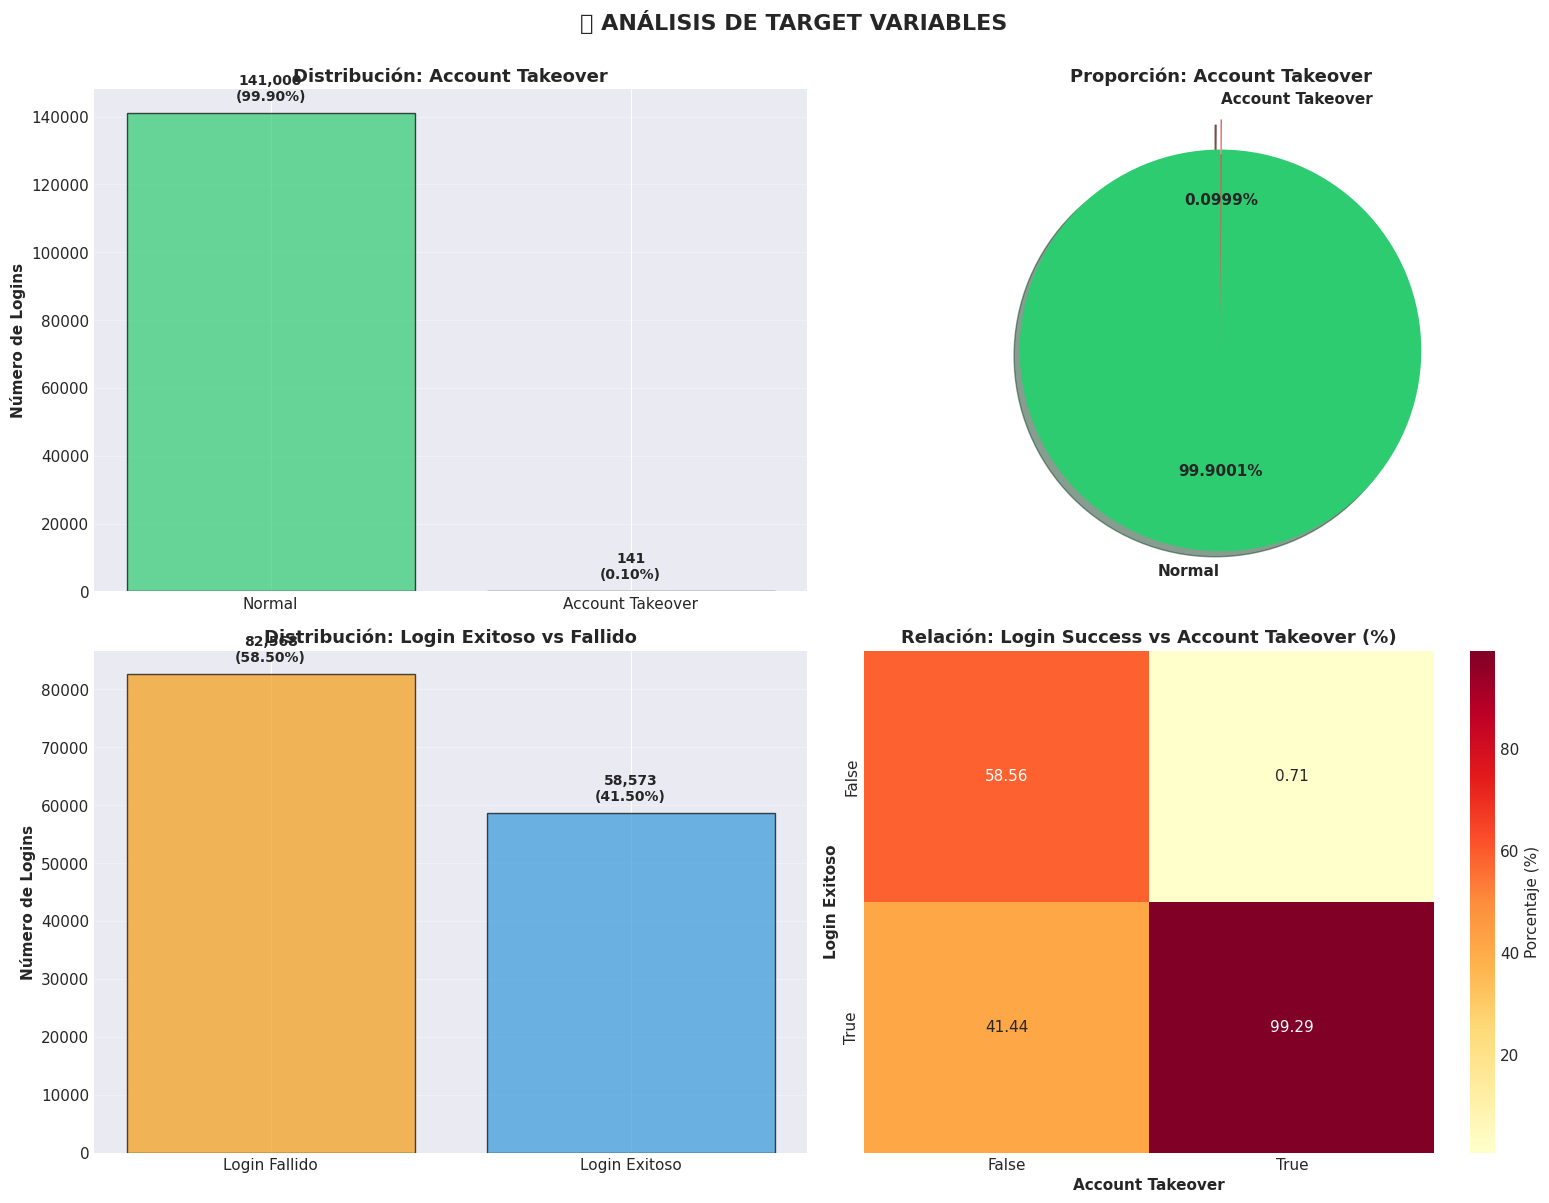

In [7]:
# VISUALIZACIÓN DE TARGET VARIABLES
# =====================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🎯 ANÁLISIS DE TARGET VARIABLES', fontsize=16, fontweight='bold', y=1.00)

# 1. Distribución de Account Takeover (Barras)
ato_labels = ['Normal', 'Account Takeover']
ato_values = [ato_counts.get(False, 0), ato_counts.get(True, 0)]
axes[0, 0].bar(ato_labels, ato_values, color=[COLOR_NORMAL, COLOR_ATTACK], alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Número de Logins', fontweight='bold')
axes[0, 0].set_title('Distribución: Account Takeover', fontweight='bold', fontsize=13)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(ato_values):
    axes[0, 0].text(i, v + max(ato_values)*0.02, f'{v:,}\n({ato_percentages.iloc[i]:.2f}%)', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. Distribución de Account Takeover (Pie con zoom)
axes[0, 1].pie(ato_values, labels=ato_labels, autopct='%1.4f%%',
              colors=[COLOR_NORMAL, COLOR_ATTACK], startangle=90, 
              explode=(0.05, 0.1), shadow=True, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[0, 1].set_title('Proporción: Account Takeover', fontweight='bold', fontsize=13)

# 3. Distribución de Login Success
login_labels = ['Login Fallido', 'Login Exitoso']
login_values = [login_counts.get(False, 0), login_counts.get(True, 0)]
axes[1, 0].bar(login_labels, login_values, color=[COLOR_FAIL, COLOR_SUCCESS], alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Número de Logins', fontweight='bold')
axes[1, 0].set_title('Distribución: Login Exitoso vs Fallido', fontweight='bold', fontsize=13)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(login_values):
    axes[1, 0].text(i, v + max(login_values)*0.02, f'{v:,}\n({login_percentages.iloc[i]:.2f}%)', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. Heatmap: Login Success vs Account Takeover
contingency_norm = pd.crosstab(df['Login Successful'], df['Is Account Takeover'], normalize='columns') * 100
sns.heatmap(contingency_norm, annot=True, fmt='.2f', cmap='YlOrRd', 
           ax=axes[1, 1], cbar_kws={'label': 'Porcentaje (%)'})
axes[1, 1].set_ylabel('Login Exitoso', fontweight='bold')
axes[1, 1].set_xlabel('Account Takeover', fontweight='bold')
axes[1, 1].set_title('Relación: Login Success vs Account Takeover (%)', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

---
# FASE 3: ANÁLISIS DE FEATURES CATEGÓRICOS
---

In [8]:
# ANÁLISIS DE BROWSER NAME AND VERSION
# =====================================================

print("🌐 ANÁLISIS DE BROWSERS")
print("=" * 100)

# Extraer nombre del browser (sin versión)
df['Browser_Name'] = df['Browser Name and Version'].str.split(' ').str[0]

# Top browsers
print("\n📊 TOP 10 BROWSERS MÁS UTILIZADOS:")
print("-" * 60)
top_browsers = df['Browser_Name'].value_counts().head(10)
display(pd.DataFrame({'Browser': top_browsers.index, 'Cantidad': top_browsers.values, 
                      'Porcentaje': (top_browsers.values/len(df)*100).round(2)}))

# Browsers en logins normales vs ATO
print("\n📊 TOP 5 BROWSERS EN LOGINS NORMALES:")
print("-" * 60)
normal_browsers = df[df['Is Account Takeover'] == False]['Browser_Name'].value_counts().head(5)
display(pd.DataFrame({'Browser': normal_browsers.index, 'Cantidad': normal_browsers.values}))

print("\n📊 TOP 5 BROWSERS EN ACCOUNT TAKEOVER:")
print("-" * 60)
ato_browsers = df[df['Is Account Takeover'] == True]['Browser_Name'].value_counts().head(5)
if len(ato_browsers) > 0:
    display(pd.DataFrame({'Browser': ato_browsers.index, 'Cantidad': ato_browsers.values}))
else:
    print("   No hay suficientes casos de ATO en la muestra para analizar browsers")

🌐 ANÁLISIS DE BROWSERS

📊 TOP 10 BROWSERS MÁS UTILIZADOS:
------------------------------------------------------------


,Browser,Cantidad,Porcentaje
0,Chrome,89100,63.13
1,Android,15847,11.23
2,Firefox,13115,9.29
3,Opera,7939,5.62
4,ZipppBot,6210,4.40
5,VLC,3036,2.15
6,startmebot,1567,1.11
7,Edge,1104,0.78
8,Snapchat,483,0.34
9,Iron,431,0.31



📊 TOP 5 BROWSERS EN LOGINS NORMALES:
------------------------------------------------------------


,Browser,Cantidad
0,Chrome,88964
1,Android,15845
2,Firefox,13114
3,Opera,7938
4,ZipppBot,6210



📊 TOP 5 BROWSERS EN ACCOUNT TAKEOVER:
------------------------------------------------------------


,Browser,Cantidad
0,Chrome,136
1,Android,2
2,Edge,1
3,Firefox,1
4,Opera,1


In [9]:
# ANÁLISIS DE OPERATING SYSTEM
# =====================================================

print("💻 ANÁLISIS DE SISTEMAS OPERATIVOS")
print("=" * 100)

# Extraer nombre del OS (sin versión)
df['OS_Name'] = df['OS Name and Version'].str.split(' ').str[0]

# Top OS
print("\n📊 TOP 10 SISTEMAS OPERATIVOS:")
print("-" * 60)
top_os = df['OS_Name'].value_counts().head(10)
display(pd.DataFrame({'OS': top_os.index, 'Cantidad': top_os.values,
                      'Porcentaje': (top_os.values/len(df)*100).round(2)}))

# OS en logins normales vs ATO
print("\n📊 COMPARACIÓN DE OS: Normal vs Account Takeover")
print("-" * 60)
os_comparison = pd.crosstab(df['OS_Name'], df['Is Account Takeover'], margins=True)
os_comparison = os_comparison.sort_values(by=True, ascending=False).head(10)
display(os_comparison)

💻 ANÁLISIS DE SISTEMAS OPERATIVOS

📊 TOP 10 SISTEMAS OPERATIVOS:
------------------------------------------------------------


,OS,Cantidad,Porcentaje
0,iOS,49903,35.36
1,Android,39746,28.16
2,Mac,29428,20.85
3,Other,11179,7.92
4,Chrome,4733,3.35
5,Windows,2565,1.82
6,Chromecast,2074,1.47
7,KaiOS,1337,0.95
8,BlackBerry,42,0.03
9,Fedora,38,0.03



📊 COMPARACIÓN DE OS: Normal vs Account Takeover
------------------------------------------------------------


Is Account Takeover,False,True,All
OS_Name,,,
All,141000,141,141141
Mac,29316,112,29428
Android,39735,11,39746
iOS,49893,10,49903
Chrome,4728,5,4733
Chromecast,2071,3,2074
BlackBerry,42,0,42
Gentoo,10,0,10
Fedora,38,0,38


In [10]:
# ANÁLISIS DE DEVICE TYPE
# =====================================================

print("📱 ANÁLISIS DE TIPOS DE DISPOSITIVO")
print("=" * 100)

# Distribución de device types
print("\n📊 DISTRIBUCIÓN DE DEVICE TYPES:")
print("-" * 60)
device_counts = df['Device Type'].value_counts()
device_percentages = (device_counts / len(df) * 100).round(2)
display(pd.DataFrame({'Device Type': device_counts.index, 'Cantidad': device_counts.values,
                      'Porcentaje': device_percentages.values}))

# Device type por Account Takeover
print("\n📊 DEVICE TYPE POR CLASE:")
print("-" * 60)
device_by_ato = pd.crosstab(df['Device Type'], df['Is Account Takeover'], normalize='columns') * 100
display(device_by_ato.round(2))

# Insights
print("\n💡 INSIGHTS CLAVE:")
print("   • Los bots son un indicador fuerte de actividad sospechosa")
print("   • El cambio de device type puede ser un feature importante")
print("   • Desktop vs Mobile puede tener patrones distintos")

📱 ANÁLISIS DE TIPOS DE DISPOSITIVO

📊 DISTRIBUCIÓN DE DEVICE TYPES:
------------------------------------------------------------


,Device Type,Cantidad,Porcentaje
0,mobile,89780,63.61
1,desktop,36317,25.73
2,bot,7950,5.63
3,tablet,3791,2.69
4,unknown,3295,2.33



📊 DEVICE TYPE POR CLASE:
------------------------------------------------------------


Is Account Takeover,False,True
Device Type,,
bot,5.64,0.00
desktop,25.67,85.11
mobile,63.66,14.18
tablet,2.69,0.71
unknown,2.34,0.00



💡 INSIGHTS CLAVE:
   • Los bots son un indicador fuerte de actividad sospechosa
   • El cambio de device type puede ser un feature importante
   • Desktop vs Mobile puede tener patrones distintos


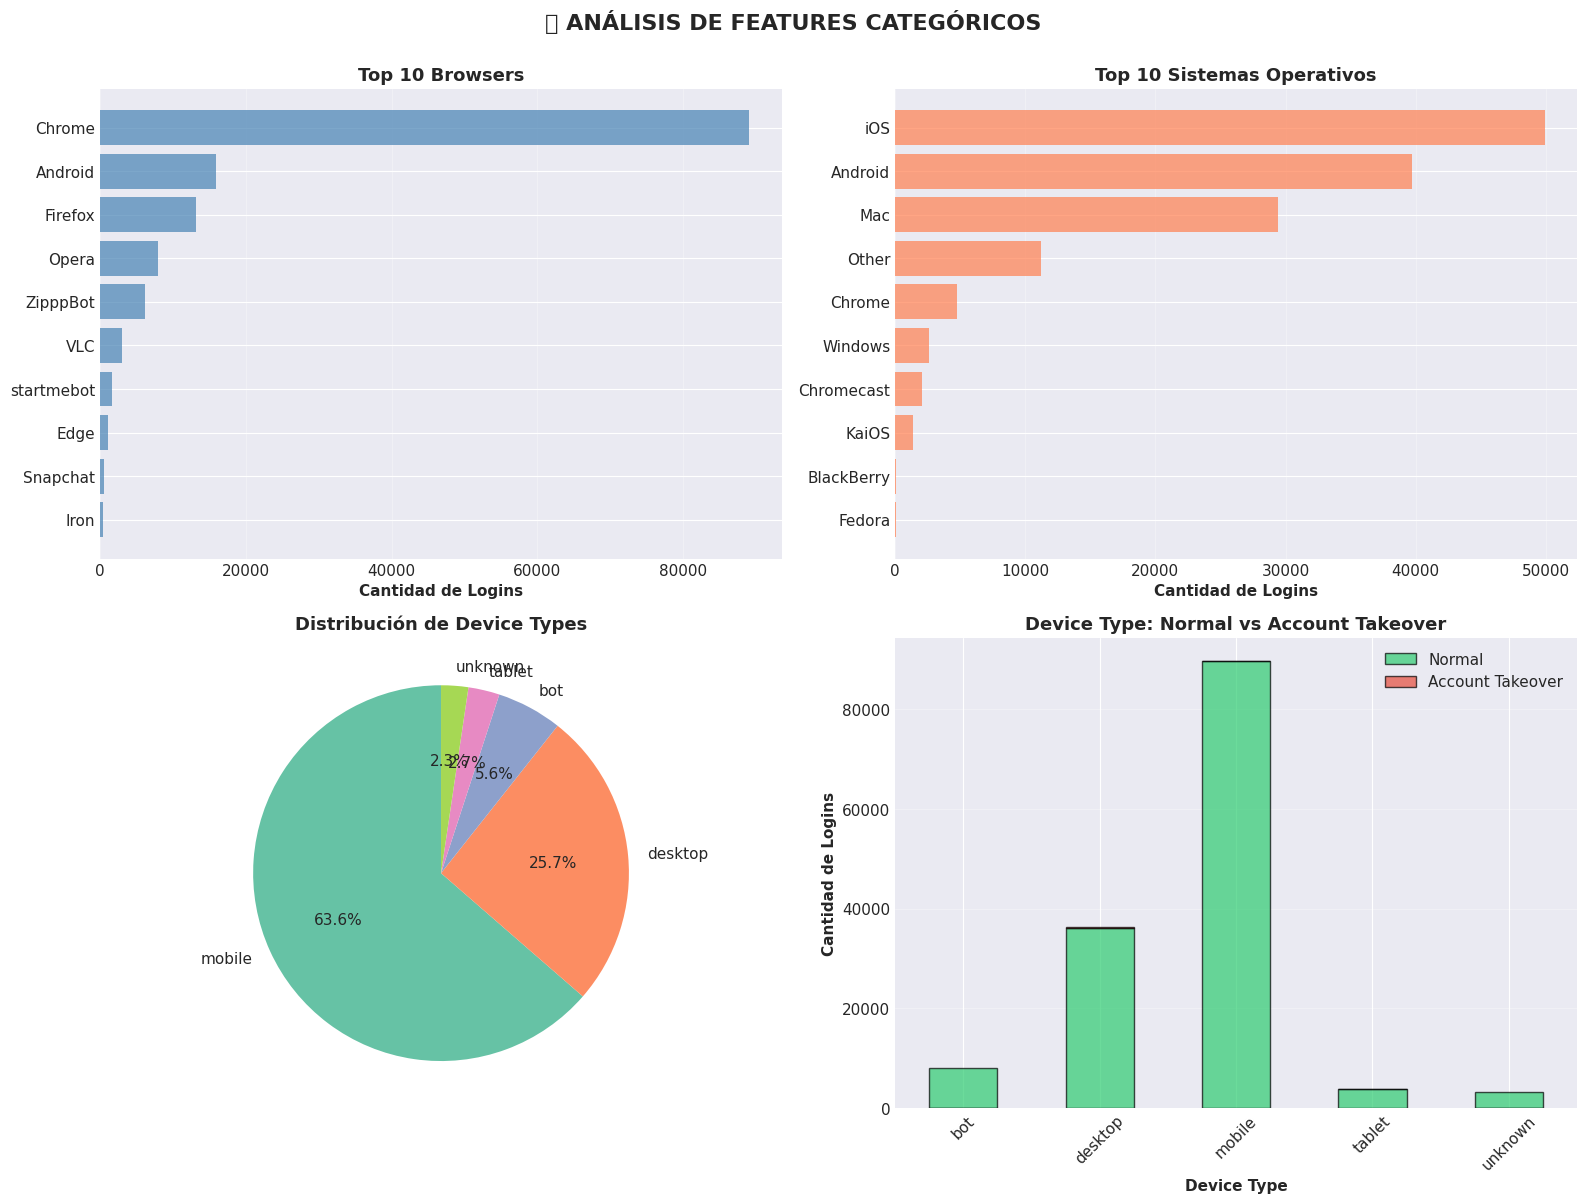

In [11]:
# VISUALIZACIÓN DE FEATURES CATEGÓRICOS
# =====================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 ANÁLISIS DE FEATURES CATEGÓRICOS', fontsize=16, fontweight='bold', y=1.00)

# 1. Top Browsers
top_browsers_plot = df['Browser_Name'].value_counts().head(10)
axes[0, 0].barh(range(len(top_browsers_plot)), top_browsers_plot.values, color='steelblue', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_browsers_plot)))
axes[0, 0].set_yticklabels(top_browsers_plot.index)
axes[0, 0].set_xlabel('Cantidad de Logins', fontweight='bold')
axes[0, 0].set_title('Top 10 Browsers', fontweight='bold', fontsize=13)
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# 2. Top OS
top_os_plot = df['OS_Name'].value_counts().head(10)
axes[0, 1].barh(range(len(top_os_plot)), top_os_plot.values, color='coral', alpha=0.7)
axes[0, 1].set_yticks(range(len(top_os_plot)))
axes[0, 1].set_yticklabels(top_os_plot.index)
axes[0, 1].set_xlabel('Cantidad de Logins', fontweight='bold')
axes[0, 1].set_title('Top 10 Sistemas Operativos', fontweight='bold', fontsize=13)
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# 3. Device Type Distribution
device_counts = df['Device Type'].value_counts()
axes[1, 0].pie(device_counts.values, labels=device_counts.index, autopct='%1.1f%%',
              startangle=90, colors=sns.color_palette('Set2', len(device_counts)))
axes[1, 0].set_title('Distribución de Device Types', fontweight='bold', fontsize=13)

# 4. Device Type por Account Takeover (stacked bar)
device_by_ato_count = pd.crosstab(df['Device Type'], df['Is Account Takeover'])
device_by_ato_count.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                         color=[COLOR_NORMAL, COLOR_ATTACK], alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Cantidad de Logins', fontweight='bold')
axes[1, 1].set_xlabel('Device Type', fontweight='bold')
axes[1, 1].set_title('Device Type: Normal vs Account Takeover', fontweight='bold', fontsize=13)
axes[1, 1].legend(['Normal', 'Account Takeover'])
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
# FASE 4: ANÁLISIS GEOGRÁFICO
---

In [12]:
# ANÁLISIS DE PAÍSES
# =====================================================

print("🌍 ANÁLISIS GEOGRÁFICO - PAÍSES")
print("=" * 100)

# Top países
print("\n📊 TOP 15 PAÍSES CON MÁS LOGINS:")
print("-" * 60)
top_countries = df['Country'].value_counts().head(15)
display(pd.DataFrame({'País': top_countries.index, 'Cantidad': top_countries.values,
                      'Porcentaje': (top_countries.values/len(df)*100).round(2)}))

# Países en ATO
print("\n📊 TOP 10 PAÍSES EN ACCOUNT TAKEOVER:")
print("-" * 60)
ato_countries = df[df['Is Account Takeover'] == True]['Country'].value_counts().head(10)
if len(ato_countries) > 0:
    display(pd.DataFrame({'País': ato_countries.index, 'Cantidad': ato_countries.values}))
    
    # Calcular tasa de ATO por país
    print("\n📊 TASA DE ACCOUNT TAKEOVER POR PAÍS (Top 15):")
    print("-" * 60)
    country_ato_rate = df.groupby('Country').agg({
        'Is Account Takeover': ['sum', 'count']
    })
    country_ato_rate.columns = ['ATO_Count', 'Total_Logins']
    country_ato_rate['ATO_Rate_%'] = (country_ato_rate['ATO_Count'] / country_ato_rate['Total_Logins'] * 100).round(4)
    country_ato_rate = country_ato_rate.sort_values('ATO_Count', ascending=False).head(15)
    display(country_ato_rate)
else:
    print("   No hay suficientes casos de ATO en la muestra para analizar países")

# País dominante (probablemente Noruega)
dominant_country = df['Country'].value_counts().index[0]
dominant_pct = df['Country'].value_counts().values[0] / len(df) * 100
print(f"\n💡 INSIGHT: El país dominante es '{dominant_country}' con {dominant_pct:.2f}% de los logins")
print("   Esto es esperado ya que el dataset proviene de un SSO en Noruega")

🌍 ANÁLISIS GEOGRÁFICO - PAÍSES

📊 TOP 15 PAÍSES CON MÁS LOGINS:
------------------------------------------------------------


,País,Cantidad,Porcentaje
0,NO,61942,43.89
1,US,37001,26.22
2,RU,6352,4.50
3,BR,5415,3.84
4,PL,4233,3.00
5,DE,4113,2.91
6,IN,2155,1.53
7,UA,2006,1.42
8,AU,1993,1.41
9,GB,1963,1.39



📊 TOP 10 PAÍSES EN ACCOUNT TAKEOVER:
------------------------------------------------------------


,País,Cantidad
0,RO,79
1,NO,10
2,BR,9
3,ID,9
4,CA,9
5,IT,7
6,DK,5
7,CL,3
8,LV,3
9,CZ,2



📊 TASA DE ACCOUNT TAKEOVER POR PAÍS (Top 15):
------------------------------------------------------------


,ATO_Count,Total_Logins,ATO_Rate_%
Country,,,
RO,79,636,12.4214
NO,10,61942,0.0161
BR,9,5415,0.1662
CA,9,720,1.2500
ID,9,1390,0.6475
IT,7,716,0.9777
DK,5,151,3.3113
LV,3,23,13.0435
CL,3,74,4.0541



💡 INSIGHT: El país dominante es 'NO' con 43.89% de los logins
   Esto es esperado ya que el dataset proviene de un SSO en Noruega


In [13]:
# ANÁLISIS DE IPs
# =====================================================

print("🌐 ANÁLISIS DE DIRECCIONES IP")
print("=" * 100)

# Estadísticas de IPs
total_ips = df['IP Address'].nunique()
total_users = df['User ID'].nunique()
print(f"\n📊 ESTADÍSTICAS GENERALES:")
print("-" * 60)
print(f"   • IPs únicas: {total_ips:,}")
print(f"   • Usuarios únicos: {total_users:,}")
print(f"   • Ratio IP/Usuario: {total_ips/total_users:.2f}")

# IPs con más usuarios (posible Credential Stuffing)
print("\n📊 TOP 10 IPs CON MÁS USUARIOS DISTINTOS:")
print("   (Posible indicador de Credential Stuffing)")
print("-" * 60)
ip_user_counts = df.groupby('IP Address')['User ID'].nunique().sort_values(ascending=False).head(10)
display(pd.DataFrame({'IP Address': ip_user_counts.index, 'Usuarios_Distintos': ip_user_counts.values}))

# Usuarios con más IPs (posible Account Takeover o VPN)
print("\n📊 TOP 10 USUARIOS CON MÁS IPs DISTINTAS:")
print("   (Posible indicador de Account Takeover o uso de VPN)")
print("-" * 60)
user_ip_counts = df.groupby('User ID')['IP Address'].nunique().sort_values(ascending=False).head(10)
display(pd.DataFrame({'User ID': user_ip_counts.index, 'IPs_Distintas': user_ip_counts.values}))

# Is Attack IP
print("\n📊 ANÁLISIS DE 'IS ATTACK IP':")
print("-" * 60)
attack_ip_counts = df['Is Attack IP'].value_counts()
attack_ip_pct = (attack_ip_counts / len(df) * 100).round(2)
print(f"   • IPs marcadas como Attack: {attack_ip_counts.get(True, 0):,} ({attack_ip_pct.get(True, 0):.2f}%)")
print(f"   • IPs normales: {attack_ip_counts.get(False, 0):,} ({attack_ip_pct.get(False, 0):.2f}%)")

# Correlación entre Attack IP y Account Takeover
if True in df['Is Attack IP'].values and True in df['Is Account Takeover'].values:
    attack_ip_ato = pd.crosstab(df['Is Attack IP'], df['Is Account Takeover'], margins=True)
    print("\n📊 RELACIÓN: Attack IP vs Account Takeover")
    print("-" * 60)
    display(attack_ip_ato)

🌐 ANÁLISIS DE DIRECCIONES IP

📊 ESTADÍSTICAS GENERALES:
------------------------------------------------------------
   • IPs únicas: 84,651
   • Usuarios únicos: 76,626
   • Ratio IP/Usuario: 1.10

📊 TOP 10 IPs CON MÁS USUARIOS DISTINTOS:
   (Posible indicador de Credential Stuffing)
------------------------------------------------------------


,IP Address,Usuarios_Distintos
0,10.0.160.77,135
1,10.0.77.226,77
2,10.0.77.228,52
3,10.0.160.76,43
4,10.0.77.229,40
5,10.0.77.225,38
6,10.0.77.227,38
7,10.0.113.55,30
8,109.203.24.19,27
9,10.0.77.224,25



📊 TOP 10 USUARIOS CON MÁS IPs DISTINTAS:
   (Posible indicador de Account Takeover o uso de VPN)
------------------------------------------------------------


,User ID,IPs_Distintas
0,-4324475583306591935,30122
1,-3550173317628772375,7
2,-4652302824165996131,7
3,-8948448241370776238,7
4,2799409437885065945,6
5,3282577277103934289,6
6,3654172331121978259,5
7,-3515349109848835805,5
8,-5870721216921566368,5
9,3170364966826867167,5



📊 ANÁLISIS DE 'IS ATTACK IP':
------------------------------------------------------------
   • IPs marcadas como Attack: 13,538 (9.59%)
   • IPs normales: 127,603 (90.41%)

📊 RELACIÓN: Attack IP vs Account Takeover
------------------------------------------------------------


Is Account Takeover,False,True,All
Is Attack IP,,,
False,127539,64,127603
True,13461,77,13538
All,141000,141,141141


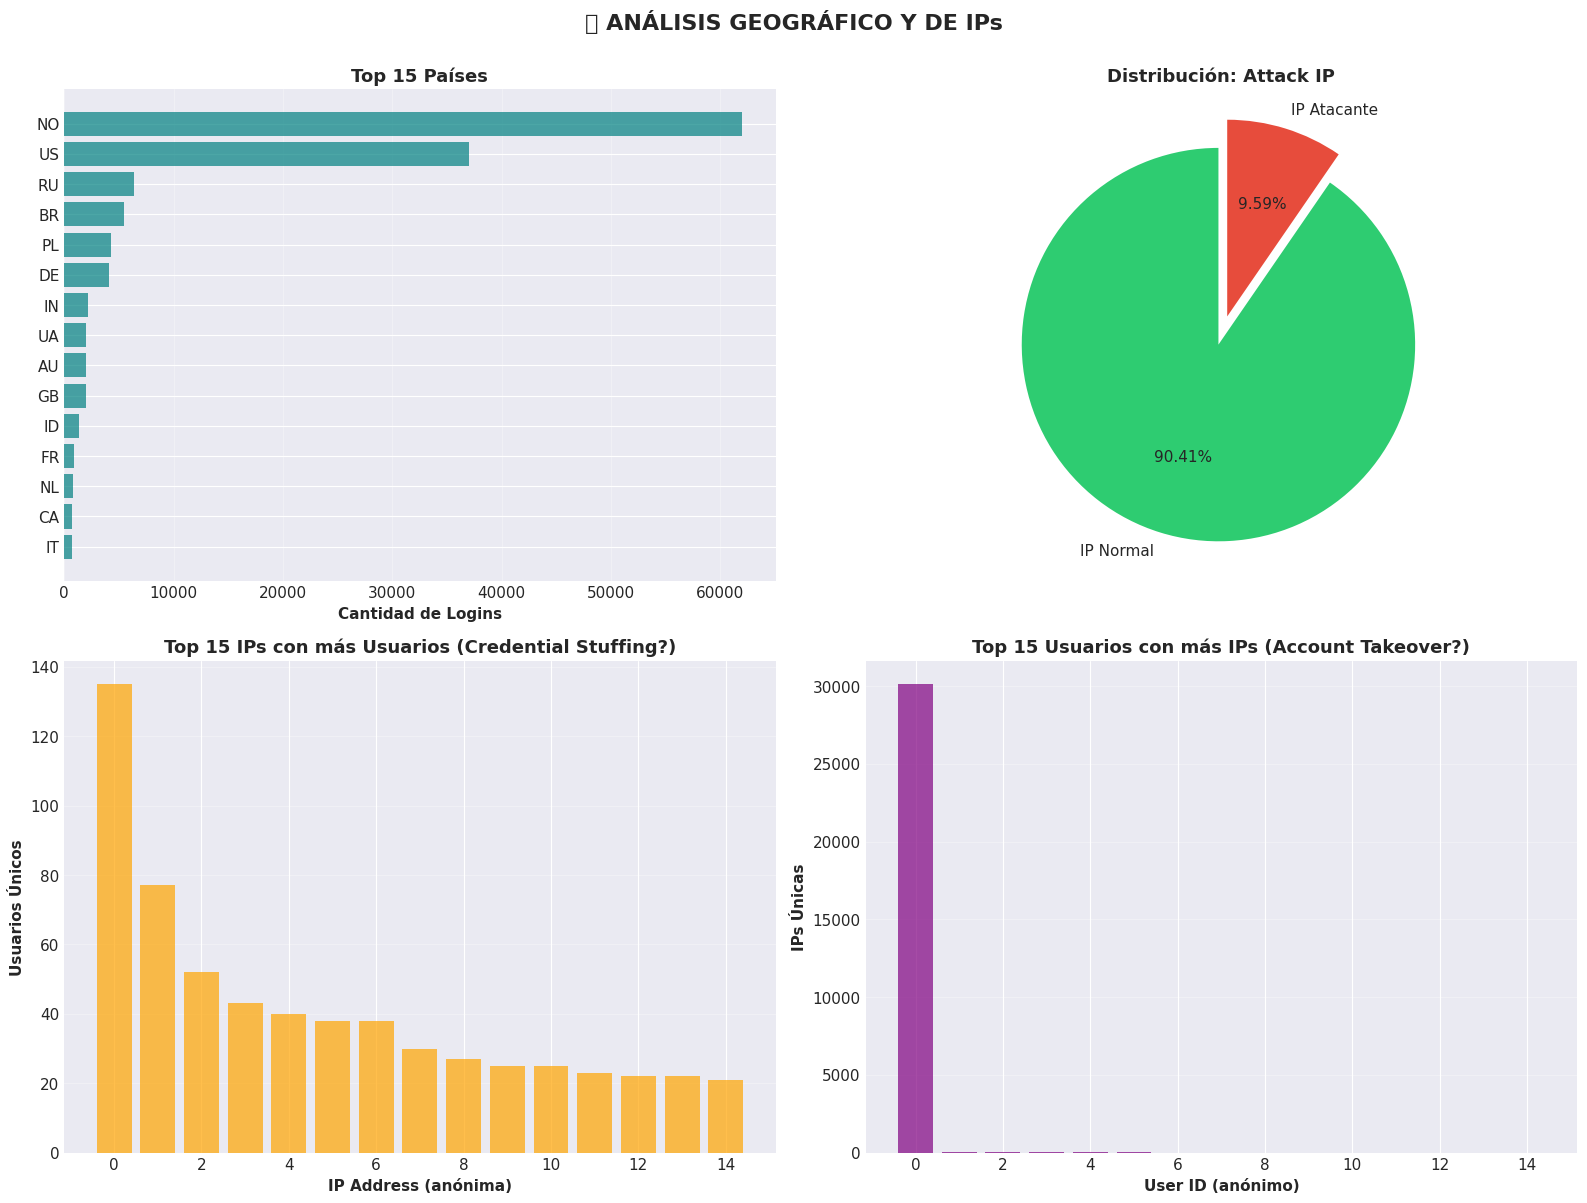

In [14]:
# VISUALIZACIÓN GEOGRÁFICA
# =====================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🌍 ANÁLISIS GEOGRÁFICO Y DE IPs', fontsize=16, fontweight='bold', y=1.00)

# 1. Top Países (horizontal bar)
top_countries_plot = df['Country'].value_counts().head(15)
axes[0, 0].barh(range(len(top_countries_plot)), top_countries_plot.values, color='teal', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_countries_plot)))
axes[0, 0].set_yticklabels(top_countries_plot.index)
axes[0, 0].set_xlabel('Cantidad de Logins', fontweight='bold')
axes[0, 0].set_title('Top 15 Países', fontweight='bold', fontsize=13)
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# 2. Distribución Attack IP
attack_ip_counts = df['Is Attack IP'].value_counts()
attack_ip_labels = ['IP Normal', 'IP Atacante']
axes[0, 1].pie(attack_ip_counts.values, labels=attack_ip_labels, autopct='%1.2f%%',
              colors=['#2ecc71', '#e74c3c'], startangle=90, explode=(0.05, 0.1))
axes[0, 1].set_title('Distribución: Attack IP', fontweight='bold', fontsize=13)

# 3. IPs con más usuarios (posible Credential Stuffing)
ip_user_counts_plot = df.groupby('IP Address')['User ID'].nunique().sort_values(ascending=False).head(15)
axes[1, 0].bar(range(len(ip_user_counts_plot)), ip_user_counts_plot.values, color='orange', alpha=0.7)
axes[1, 0].set_xlabel('IP Address (anónima)', fontweight='bold')
axes[1, 0].set_ylabel('Usuarios Únicos', fontweight='bold')
axes[1, 0].set_title('Top 15 IPs con más Usuarios (Credential Stuffing?)', fontweight='bold', fontsize=13)
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Usuarios con más IPs (posible Account Takeover)
user_ip_counts_plot = df.groupby('User ID')['IP Address'].nunique().sort_values(ascending=False).head(15)
axes[1, 1].bar(range(len(user_ip_counts_plot)), user_ip_counts_plot.values, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('User ID (anónimo)', fontweight='bold')
axes[1, 1].set_ylabel('IPs Únicas', fontweight='bold')
axes[1, 1].set_title('Top 15 Usuarios con más IPs (Account Takeover?)', fontweight='bold', fontsize=13)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
# FASE 5: ANÁLISIS TEMPORAL
---

In [15]:
# ANÁLISIS TEMPORAL
# =====================================================

print("📅 ANÁLISIS TEMPORAL DE LOGINS")
print("=" * 100)

# Parsear timestamps
df['datetime'] = pd.to_datetime(df['Login Timestamp'], errors='coerce')

# Validar fechas
valid_dates = df['datetime'].notna().sum()
print("\n📊 VALIDACIÓN DE TIMESTAMPS:")
print("-" * 60)
print(f"   • Timestamps válidos: {valid_dates:,} ({valid_dates/len(df)*100:.2f}%)")
print(f"   • Timestamps inválidos: {len(df) - valid_dates:,}")

if valid_dates > 0:
    # Extraer componentes temporales
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['day_name'] = df['datetime'].dt.day_name()
    df['date_only'] = df['datetime'].dt.date
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    
    # Rango temporal
    datetime_valid = df['datetime'].dropna()
    print("\n📊 INFORMACIÓN TEMPORAL:")
    print("-" * 60)
    print(f"   • Fecha más antigua: {datetime_valid.min()}")
    print(f"   • Fecha más reciente: {datetime_valid.max()}")
    print(f"   • Rango temporal: {(datetime_valid.max() - datetime_valid.min()).days} días")
    
    # Distribución por hora
    print("\n📊 DISTRIBUCIÓN HORARIA (Top 10 horas):")
    print("-" * 60)
    hour_dist = df['hour'].value_counts().sort_index().head(10)
    display(pd.DataFrame({'Hora': hour_dist.index, 'Logins': hour_dist.values}))
    
    # Distribución por día de la semana
    print("\n📊 DISTRIBUCIÓN POR DÍA DE LA SEMANA:")
    print("-" * 60)
    day_dist = df['day_name'].value_counts()
    display(pd.DataFrame({'Día': day_dist.index, 'Logins': day_dist.values}))
    
else:
    print("\n⚠️ ADVERTENCIA: No hay timestamps válidos para analizar")

📅 ANÁLISIS TEMPORAL DE LOGINS

📊 VALIDACIÓN DE TIMESTAMPS:
------------------------------------------------------------
   • Timestamps válidos: 141,141 (100.00%)
   • Timestamps inválidos: 0

📊 INFORMACIÓN TEMPORAL:
------------------------------------------------------------
   • Fecha más antigua: 2020-02-03 12:47:34.121000
   • Fecha más reciente: 2021-01-01 09:19:28.776000
   • Rango temporal: 332 días

📊 DISTRIBUCIÓN HORARIA (Top 10 horas):
------------------------------------------------------------


,Hora,Logins
0,0,1908
1,1,2366
2,2,2753
3,3,3086
4,4,3774
5,5,4658
6,6,6202
7,7,7103
8,8,7721
9,9,7902



📊 DISTRIBUCIÓN POR DÍA DE LA SEMANA:
------------------------------------------------------------


,Día,Logins
0,Tuesday,21758
1,Monday,21257
2,Wednesday,21156
3,Thursday,20950
4,Friday,19977
5,Sunday,18387
6,Saturday,17656


In [16]:
# PATRONES TEMPORALES EN ACCOUNT TAKEOVER
# =====================================================

if valid_dates > 0:
    print("🕐 PATRONES TEMPORALES EN ACCOUNT TAKEOVER")
    print("=" * 100)
    
    # Distribución horaria por clase
    print("\n📊 DISTRIBUCIÓN HORARIA: Normal vs Account Takeover")
    print("-" * 60)
    hourly_comparison = pd.crosstab(df['hour'], df['Is Account Takeover'])
    display(hourly_comparison.head(10))
    
    # Distribución por día de la semana por clase
    print("\n📊 DISTRIBUCIÓN SEMANAL: Normal vs Account Takeover")
    print("-" * 60)
    daily_comparison = pd.crosstab(df['day_name'], df['Is Account Takeover'])
    display(daily_comparison)
    
    # Estadísticas clave
    if True in df['Is Account Takeover'].values:
        ato_hours = df[df['Is Account Takeover'] == True]['hour'].value_counts().sort_values(ascending=False)
        normal_hours = df[df['Is Account Takeover'] == False]['hour'].value_counts().sort_values(ascending=False)
        
        print("\n💡 INSIGHTS TEMPORALES:")
        if len(ato_hours) > 0:
            print(f"   • Hora con más Account Takeover: {ato_hours.index[0]}:00 hrs")
            print(f"   • Hora con más logins normales: {normal_hours.index[0]}:00 hrs")
            print("   • Los atacantes pueden tener patrones horarios distintos a usuarios legítimos")

🕐 PATRONES TEMPORALES EN ACCOUNT TAKEOVER

📊 DISTRIBUCIÓN HORARIA: Normal vs Account Takeover
------------------------------------------------------------


Is Account Takeover,False,True
hour,,
0,1902,6
1,2363,3
2,2752,1
3,3085,1
4,3772,2
5,4654,4
6,6196,6
7,7098,5
8,7717,4



📊 DISTRIBUCIÓN SEMANAL: Normal vs Account Takeover
------------------------------------------------------------


Is Account Takeover,False,True
day_name,,
Friday,19955,22
Monday,21232,25
Saturday,17640,16
Sunday,18364,23
Thursday,20928,22
Tuesday,21741,17
Wednesday,21140,16



💡 INSIGHTS TEMPORALES:
   • Hora con más Account Takeover: 18:00 hrs
   • Hora con más logins normales: 16:00 hrs
   • Los atacantes pueden tener patrones horarios distintos a usuarios legítimos


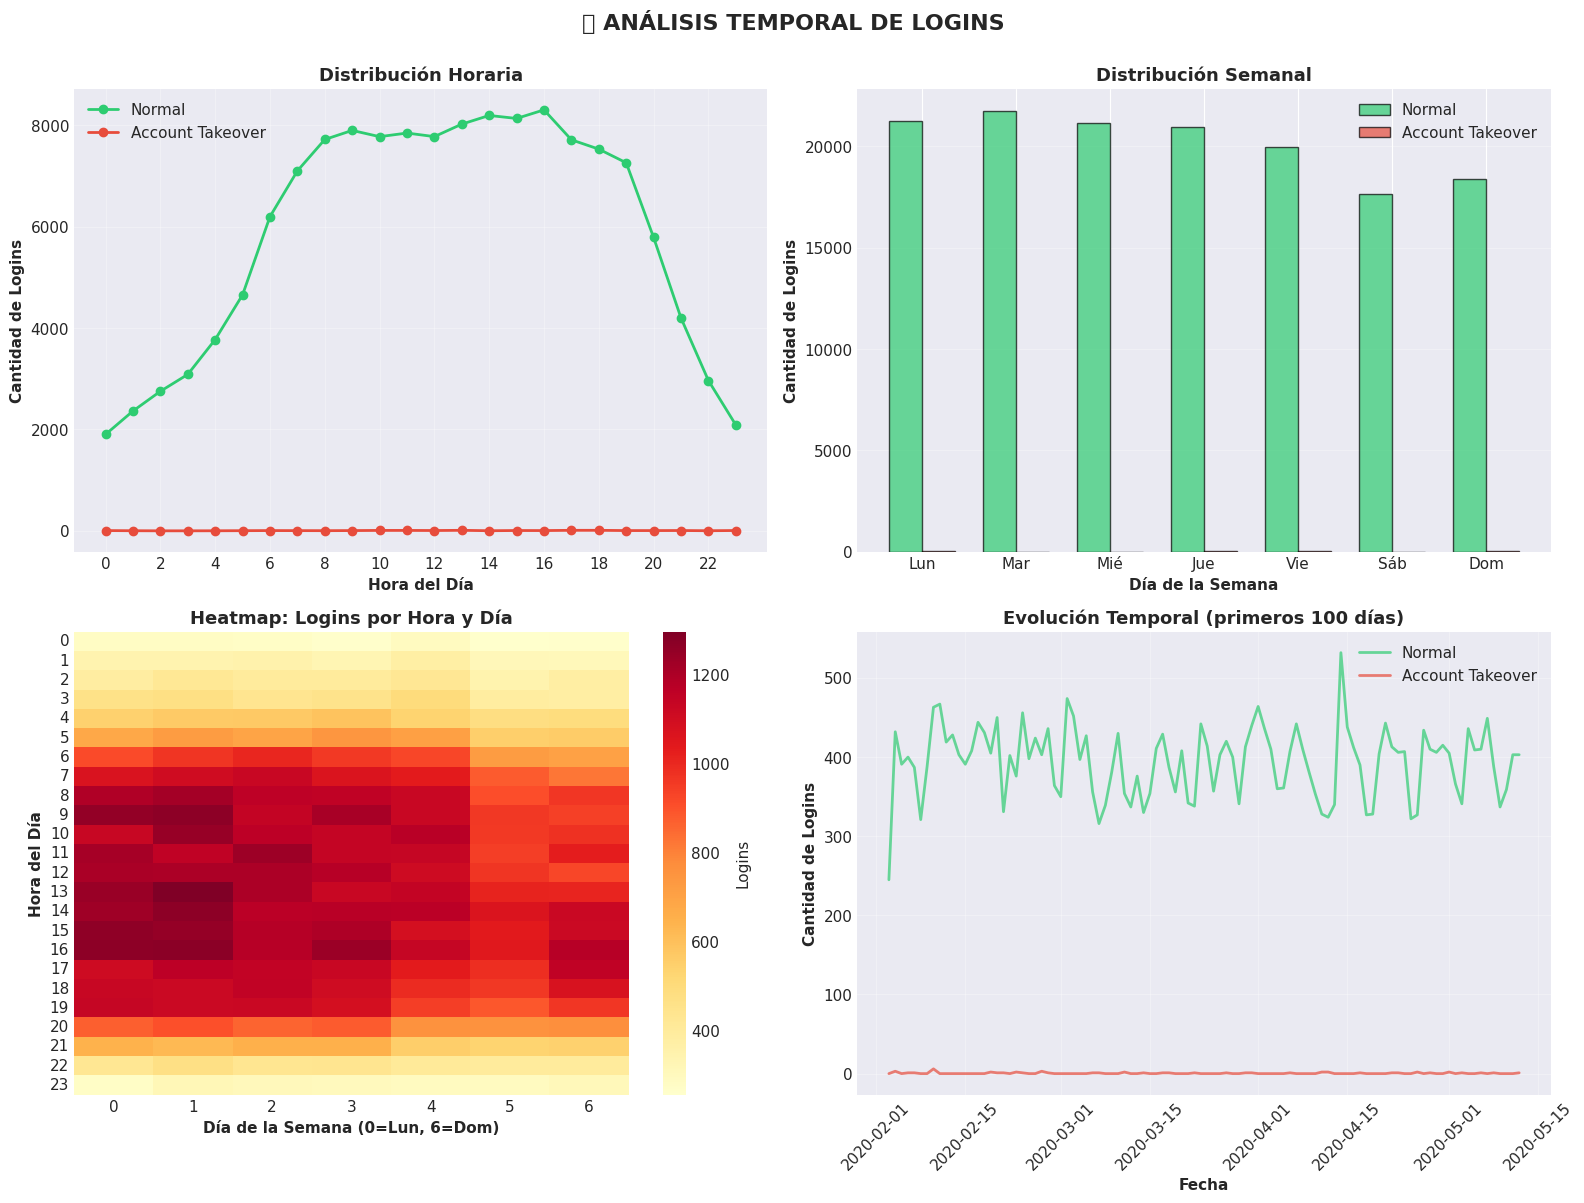

In [17]:
# VISUALIZACIÓN TEMPORAL
# =====================================================

if valid_dates > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('📅 ANÁLISIS TEMPORAL DE LOGINS', fontsize=16, fontweight='bold', y=1.00)
    
    # 1. Distribución horaria
    for ato_value in [False, True]:
        data = df[df['Is Account Takeover'] == ato_value]['hour'].value_counts().sort_index()
        label = 'Normal' if ato_value == False else 'Account Takeover'
        color = COLOR_NORMAL if ato_value == False else COLOR_ATTACK
        axes[0, 0].plot(data.index, data.values, marker='o', label=label, color=color, linewidth=2)
    axes[0, 0].set_xlabel('Hora del Día', fontweight='bold')
    axes[0, 0].set_ylabel('Cantidad de Logins', fontweight='bold')
    axes[0, 0].set_title('Distribución Horaria', fontweight='bold', fontsize=13)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].set_xticks(range(0, 24, 2))
    
    # 2. Distribución semanal
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts_normal = df[df['Is Account Takeover'] == False]['day_name'].value_counts().reindex(days_order, fill_value=0)
    day_counts_ato = df[df['Is Account Takeover'] == True]['day_name'].value_counts().reindex(days_order, fill_value=0)
    
    x = np.arange(len(days_order))
    width = 0.35
    axes[0, 1].bar(x - width/2, day_counts_normal.values, width, label='Normal', 
                  color=COLOR_NORMAL, alpha=0.7, edgecolor='black')
    axes[0, 1].bar(x + width/2, day_counts_ato.values, width, label='Account Takeover', 
                  color=COLOR_ATTACK, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Día de la Semana', fontweight='bold')
    axes[0, 1].set_ylabel('Cantidad de Logins', fontweight='bold')
    axes[0, 1].set_title('Distribución Semanal', fontweight='bold', fontsize=13)
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. Heatmap: Hora x Día de la semana
    sample_temporal = df.dropna(subset=['hour', 'day_of_week'])
    if len(sample_temporal) > 0:
        pivot_data = sample_temporal.pivot_table(values='User ID', index='hour', 
                                                 columns='day_of_week', aggfunc='count', fill_value=0)
        sns.heatmap(pivot_data, ax=axes[1, 0], cmap='YlOrRd', cbar_kws={'label': 'Logins'})
        axes[1, 0].set_xlabel('Día de la Semana (0=Lun, 6=Dom)', fontweight='bold')
        axes[1, 0].set_ylabel('Hora del Día', fontweight='bold')
        axes[1, 0].set_title('Heatmap: Logins por Hora y Día', fontweight='bold', fontsize=13)
    
    # 4. Evolución temporal (sample de días)
    daily_data = df.dropna(subset=['date_only'])
    if len(daily_data) > 0:
        daily_counts = daily_data.groupby(['date_only', 'Is Account Takeover']).size().unstack(fill_value=0)
        if len(daily_counts) > 100:
            daily_counts = daily_counts.iloc[:100]  # Primeros 100 días para visualización
        daily_counts.plot(ax=axes[1, 1], color=[COLOR_NORMAL, COLOR_ATTACK], alpha=0.7, linewidth=2)
        axes[1, 1].set_xlabel('Fecha', fontweight='bold')
        axes[1, 1].set_ylabel('Cantidad de Logins', fontweight='bold')
        axes[1, 1].set_title('Evolución Temporal (primeros 100 días)', fontweight='bold', fontsize=13)
        axes[1, 1].legend(['Normal', 'Account Takeover'])
        axes[1, 1].grid(alpha=0.3)
        axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se pueden generar visualizaciones temporales")

---
# FASE 6: ANÁLISIS DE FEATURES NUMÉRICOS
---

In [18]:
# ANÁLISIS DE ROUND-TRIP TIME (RTT)
# =====================================================

print("⏱️ ANÁLISIS DE ROUND-TRIP TIME (RTT)")
print("=" * 100)

# Renombrar columna si tiene espacios
if 'Round-Trip Time [ms]' in df.columns:
    df['RTT_ms'] = df['Round-Trip Time [ms]']

# Estadísticas generales
print("\n📊 ESTADÍSTICAS DE RTT (milisegundos):")
print("-" * 60)
print(df['RTT_ms'].describe())

# Comparación por clase
print("\n📊 RTT POR CLASE:")
print("-" * 60)
for ato_value in [False, True]:
    label = "Normal" if ato_value == False else "Account Takeover"
    rtt_subset = df[df['Is Account Takeover'] == ato_value]['RTT_ms'].dropna()
    if len(rtt_subset) > 0:
        print(f"\n🔹 {label}:")
        print(f"   • Media: {rtt_subset.mean():.2f} ms")
        print(f"   • Mediana: {rtt_subset.median():.2f} ms")
        print(f"   • Desv. Estándar: {rtt_subset.std():.2f} ms")
        print(f"   • Min: {rtt_subset.min():.2f} ms")
        print(f"   • Max: {rtt_subset.max():.2f} ms")

# Test estadístico (si hay suficientes datos)
if True in df['Is Account Takeover'].values:
    normal_rtt = df[df['Is Account Takeover'] == False]['RTT_ms'].dropna()
    ato_rtt = df[df['Is Account Takeover'] == True]['RTT_ms'].dropna()
    
    if len(normal_rtt) > 30 and len(ato_rtt) > 30:
        t_stat, p_value = stats.ttest_ind(normal_rtt, ato_rtt)
        print(f"\n📊 TEST T-STUDENT:")
        print("-" * 60)
        print(f"   • t-statistic: {t_stat:.4f}")
        print(f"   • p-value: {p_value:.4e}")
        if p_value < 0.05:
            print("   • ✅ Diferencia estadísticamente significativa (p < 0.05)")
        else:
            print("   • ❌ No hay diferencia estadísticamente significativa (p >= 0.05)")

⏱️ ANÁLISIS DE ROUND-TRIP TIME (RTT)

📊 ESTADÍSTICAS DE RTT (milisegundos):
------------------------------------------------------------
count      6135.000000
mean        719.068623
std        2695.379508
min          10.000000
25%         473.000000
50%         540.000000
75%         680.000000
max      130110.000000
Name: RTT_ms, dtype: float64

📊 RTT POR CLASE:
------------------------------------------------------------

🔹 Normal:
   • Media: 719.08 ms
   • Mediana: 540.00 ms
   • Desv. Estándar: 2695.60 ms
   • Min: 10.00 ms
   • Max: 130110.00 ms

🔹 Account Takeover:
   • Media: 673.00 ms
   • Mediana: 673.00 ms
   • Desv. Estándar: nan ms
   • Min: 673.00 ms
   • Max: 673.00 ms


In [19]:
# ANÁLISIS DE ASN (AUTONOMOUS SYSTEM NUMBER)
# =====================================================

print("🌐 ANÁLISIS DE ASN (Autonomous System Number)")
print("=" * 100)

# Top ASNs
print("\n📊 TOP 15 ASNs MÁS FRECUENTES:")
print("-" * 60)
top_asn = df['ASN'].value_counts().head(15)
display(pd.DataFrame({'ASN': top_asn.index, 'Cantidad': top_asn.values,
                      'Porcentaje': (top_asn.values/len(df)*100).round(2)}))

# ASNs en Account Takeover
if True in df['Is Account Takeover'].values:
    print("\n📊 TOP 10 ASNs EN ACCOUNT TAKEOVER:")
    print("-" * 60)
    ato_asn = df[df['Is Account Takeover'] == True]['ASN'].value_counts().head(10)
    if len(ato_asn) > 0:
        display(pd.DataFrame({'ASN': ato_asn.index, 'Cantidad': ato_asn.values}))

print("\n💡 INSIGHT: ASN puede ayudar a identificar proveedores de internet asociados con ataques")

🌐 ANÁLISIS DE ASN (Autonomous System Number)

📊 TOP 15 ASNs MÁS FRECUENTES:
------------------------------------------------------------


,ASN,Cantidad,Porcentaje
0,29695,38219,27.08
1,393398,30826,21.84
2,41164,6697,4.74
3,262582,6482,4.59
4,15599,6214,4.40
5,29492,4065,2.88
6,15659,3955,2.80
7,205727,1807,1.28
8,25400,1778,1.26
9,54903,1714,1.21



📊 TOP 10 ASNs EN ACCOUNT TAKEOVER:
------------------------------------------------------------


,ASN,Cantidad
0,206801,18
1,197175,16
2,62350,15
3,61353,7
4,197475,7
5,3280,7
6,41560,5
7,501775,4
8,266130,4
9,31028,4



💡 INSIGHT: ASN puede ayudar a identificar proveedores de internet asociados con ataques


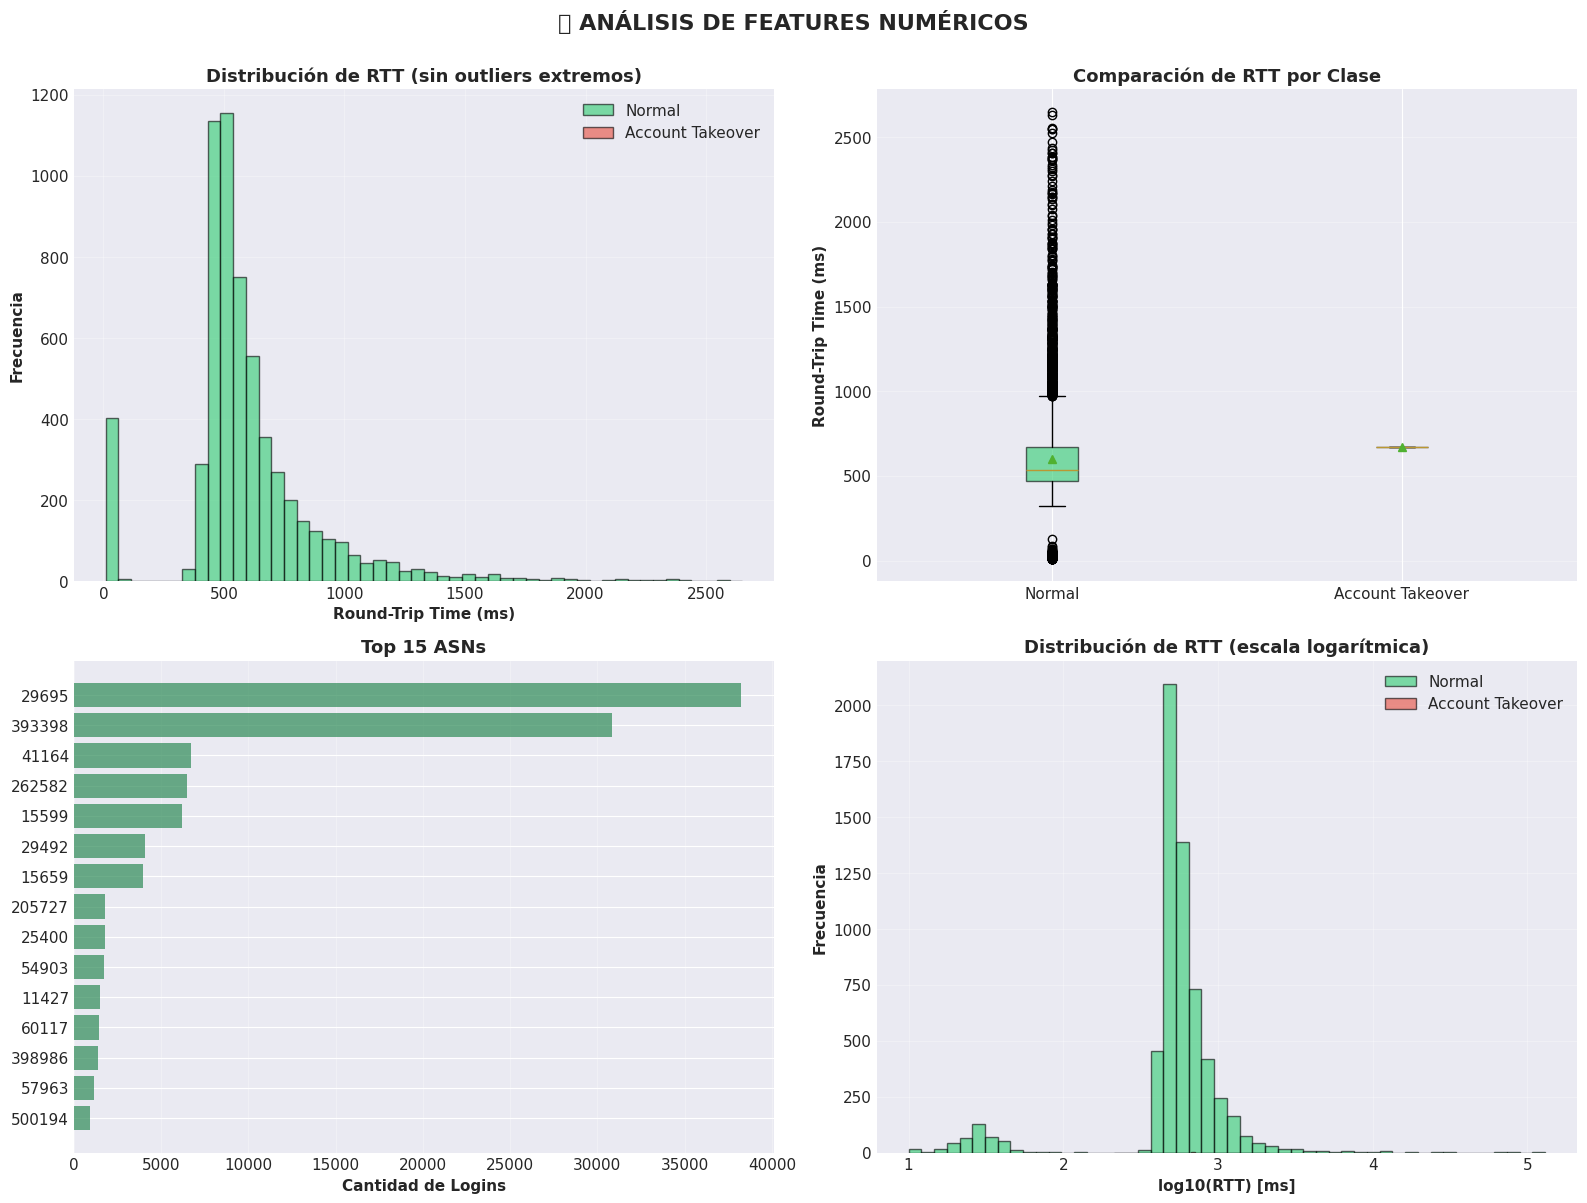

In [20]:
# VISUALIZACIÓN DE FEATURES NUMÉRICOS
# =====================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 ANÁLISIS DE FEATURES NUMÉRICOS', fontsize=16, fontweight='bold', y=1.00)

# 1. Distribución de RTT (con límite para outliers)
rtt_data = df['RTT_ms'].dropna()
if len(rtt_data) > 0:
    # Filtrar outliers extremos para visualización
    rtt_q99 = rtt_data.quantile(0.99)
    rtt_filtered = rtt_data[rtt_data <= rtt_q99]
    
    for ato_value in [False, True]:
        data = df[df['Is Account Takeover'] == ato_value]['RTT_ms'].dropna()
        data = data[data <= rtt_q99]
        label = 'Normal' if ato_value == False else 'Account Takeover'
        color = COLOR_NORMAL if ato_value == False else COLOR_ATTACK
        axes[0, 0].hist(data, bins=50, alpha=0.6, label=label, color=color, edgecolor='black')
    axes[0, 0].set_xlabel('Round-Trip Time (ms)', fontweight='bold')
    axes[0, 0].set_ylabel('Frecuencia', fontweight='bold')
    axes[0, 0].set_title('Distribución de RTT (sin outliers extremos)', fontweight='bold', fontsize=13)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

# 2. Boxplot de RTT por clase
rtt_data_normal = df[df['Is Account Takeover'] == False]['RTT_ms'].dropna()
rtt_data_ato = df[df['Is Account Takeover'] == True]['RTT_ms'].dropna()
if len(rtt_data_normal) > 0 and len(rtt_data_ato) > 0:
    # Filtrar outliers para visualización
    rtt_q99_normal = rtt_data_normal.quantile(0.99)
    rtt_q99_ato = rtt_data_ato.quantile(0.99)
    data_to_plot = [
        rtt_data_normal[rtt_data_normal <= rtt_q99_normal],
        rtt_data_ato[rtt_data_ato <= rtt_q99_ato]
    ]
    bp = axes[0, 1].boxplot(data_to_plot, labels=['Normal', 'Account Takeover'], 
                            patch_artist=True, showmeans=True)
    for patch, color in zip(bp['boxes'], [COLOR_NORMAL, COLOR_ATTACK]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[0, 1].set_ylabel('Round-Trip Time (ms)', fontweight='bold')
    axes[0, 1].set_title('Comparación de RTT por Clase', fontweight='bold', fontsize=13)
    axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Top ASNs
top_asn_plot = df['ASN'].value_counts().head(15)
axes[1, 0].barh(range(len(top_asn_plot)), top_asn_plot.values, color='seagreen', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_asn_plot)))
axes[1, 0].set_yticklabels(top_asn_plot.index)
axes[1, 0].set_xlabel('Cantidad de Logins', fontweight='bold')
axes[1, 0].set_title('Top 15 ASNs', fontweight='bold', fontsize=13)
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].invert_yaxis()

# 4. Distribución de RTT (log scale para ver outliers)
if len(rtt_data) > 0:
    for ato_value in [False, True]:
        data = df[df['Is Account Takeover'] == ato_value]['RTT_ms'].dropna()
        data = data[data > 0]  # Solo valores positivos para log
        label = 'Normal' if ato_value == False else 'Account Takeover'
        color = COLOR_NORMAL if ato_value == False else COLOR_ATTACK
        axes[1, 1].hist(np.log10(data), bins=50, alpha=0.6, label=label, color=color, edgecolor='black')
    axes[1, 1].set_xlabel('log10(RTT) [ms]', fontweight='bold')
    axes[1, 1].set_ylabel('Frecuencia', fontweight='bold')
    axes[1, 1].set_title('Distribución de RTT (escala logarítmica)', fontweight='bold', fontsize=13)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

---
# FASE 7: FEATURE ENGINEERING INSIGHTS
---

In [21]:
# ANÁLISIS DE COMPORTAMIENTO DE USUARIO
# =====================================================

print("👤 ANÁLISIS DE COMPORTAMIENTO DE USUARIO")
print("=" * 100)

# Intentos de login por usuario
print("\n📊 INTENTOS DE LOGIN POR USUARIO:")
print("-" * 60)
user_login_counts = df.groupby('User ID').size()
print(f"   • Media de logins por usuario: {user_login_counts.mean():.2f}")
print(f"   • Mediana de logins por usuario: {user_login_counts.median():.2f}")
print(f"   • Usuario con más logins: {user_login_counts.max()} logins")
print(f"   • Usuario con menos logins: {user_login_counts.min()} logins")

# Tasa de éxito por usuario
print("\n📊 TASA DE ÉXITO DE LOGIN POR USUARIO:")
print("-" * 60)
user_success_rate = df.groupby('User ID')['Login Successful'].mean()
print(f"   • Media de tasa de éxito: {user_success_rate.mean()*100:.2f}%")
print(f"   • Mediana de tasa de éxito: {user_success_rate.median()*100:.2f}%")

# Usuarios con cambio de IP
print("\n📊 CAMBIOS DE IP POR USUARIO:")
print("-" * 60)
user_ip_changes = df.groupby('User ID')['IP Address'].nunique()
print(f"   • Media de IPs por usuario: {user_ip_changes.mean():.2f}")
print(f"   • Mediana de IPs por usuario: {user_ip_changes.median():.2f}")
print(f"   • Usuarios con 1 IP única: {(user_ip_changes == 1).sum():,}")
print(f"   • Usuarios con >5 IPs: {(user_ip_changes > 5).sum():,}")
print(f"   • Usuarios con >10 IPs: {(user_ip_changes > 10).sum():,}")

# Usuarios con cambio de país
print("\n📊 CAMBIOS DE PAÍS POR USUARIO:")
print("-" * 60)
user_country_changes = df.groupby('User ID')['Country'].nunique()
print(f"   • Media de países por usuario: {user_country_changes.mean():.2f}")
print(f"   • Usuarios con 1 país único: {(user_country_changes == 1).sum():,}")
print(f"   • Usuarios con >2 países: {(user_country_changes > 2).sum():,}")

# Usuarios con cambio de browser
print("\n📊 CAMBIOS DE BROWSER POR USUARIO:")
print("-" * 60)
user_browser_changes = df.groupby('User ID')['Browser_Name'].nunique()
print(f"   • Media de browsers por usuario: {user_browser_changes.mean():.2f}")
print(f"   • Usuarios con 1 browser único: {(user_browser_changes == 1).sum():,}")
print(f"   • Usuarios con >3 browsers: {(user_browser_changes > 3).sum():,}")

print("\n💡 INSIGHTS PARA FEATURE ENGINEERING:")
print("-" * 60)
print("   1. Usuarios con múltiples IPs/países son candidatos a Account Takeover")
print("   2. Cambios súbitos de browser/device pueden indicar compromiso")
print("   3. Tasa de éxito muy baja puede indicar brute force")
print("   4. Features recomendados:")
print("      - ip_count_last_N_days")
print("      - country_changed_from_normal")
print("      - browser_changed_from_normal")
print("      - failed_attempts_last_N_minutes")
print("      - time_since_last_login")
print("      - impossible_travel_detected")

👤 ANÁLISIS DE COMPORTAMIENTO DE USUARIO

📊 INTENTOS DE LOGIN POR USUARIO:
------------------------------------------------------------
   • Media de logins por usuario: 1.84
   • Mediana de logins por usuario: 1.00
   • Usuario con más logins: 60992 logins
   • Usuario con menos logins: 1 logins

📊 TASA DE ÉXITO DE LOGIN POR USUARIO:
------------------------------------------------------------
   • Media de tasa de éxito: 72.93%
   • Mediana de tasa de éxito: 100.00%

📊 CAMBIOS DE IP POR USUARIO:
------------------------------------------------------------
   • Media de IPs por usuario: 1.42
   • Mediana de IPs por usuario: 1.00
   • Usuarios con 1 IP única: 74,875
   • Usuarios con >5 IPs: 6
   • Usuarios con >10 IPs: 1

📊 CAMBIOS DE PAÍS POR USUARIO:
------------------------------------------------------------
   • Media de países por usuario: 1.00
   • Usuarios con 1 país único: 76,561
   • Usuarios con >2 países: 3

📊 CAMBIOS DE BROWSER POR USUARIO:
--------------------------------

---
# FASE 8: CONCLUSIONES Y RECOMENDACIONES
---

In [22]:
# RESUMEN EJECUTIVO DEL EDA
# =====================================================

print("📌 RESUMEN EJECUTIVO - EDA DATASET RBA (ACCESOS SOSPECHOSOS)")
print("=" * 100)

# Estadísticas generales
total_logins = len(df)
total_users = df['User ID'].nunique()
total_ips = df['IP Address'].nunique()
ato_count = df['Is Account Takeover'].sum() if True in df['Is Account Takeover'].values else 0
ato_rate = (ato_count / total_logins * 100) if total_logins > 0 else 0

print("\n📊 ESTADÍSTICAS GENERALES (MUESTRA):")
print("-" * 60)
print(f"   • Total de logins analizados: {total_logins:,}")
print(f"   • Usuarios únicos: {total_users:,}")
print(f"   • IPs únicas: {total_ips:,}")
print(f"   • Account Takeover detectados: {ato_count:,} ({ato_rate:.4f}%)")
print(f"   • Balance del dataset: {'EXTREMADAMENTE DESBALANCEADO' if ato_rate < 1 else 'DESBALANCEADO'}")

# Features categóricos
print("\n🌐 FEATURES CATEGÓRICOS:")
print("-" * 60)
print(f"   • Browsers únicos: {df['Browser_Name'].nunique()}")
print(f"   • OS únicos: {df['OS_Name'].nunique()}")
print(f"   • Device types: {df['Device Type'].nunique()}")
print(f"   • Países únicos: {df['Country'].nunique()}")

# Features numéricos
print("\n⏱️ FEATURES NUMÉRICOS:")
print("-" * 60)
if 'RTT_ms' in df.columns:
    print(f"   • RTT promedio: {df['RTT_ms'].mean():.2f} ms")
    print(f"   • RTT mediana: {df['RTT_ms'].median():.2f} ms")
print(f"   • ASNs únicos: {df['ASN'].nunique()}")

# Temporal
if valid_dates > 0:
    print("\n📅 INFORMACIÓN TEMPORAL:")
    print("-" * 60)
    print(f"   • Rango temporal: {(df['datetime'].max() - df['datetime'].min()).days} días")
    print(f"   • Hora con más actividad: {df['hour'].value_counts().index[0]}:00 hrs")
    print(f"   • Día con más actividad: {df['day_name'].value_counts().index[0]}")

# Calidad de datos
print("\n✅ CALIDAD DE DATOS:")
print("-" * 60)
print(f"   • Valores nulos totales: {df.isnull().sum().sum():,}")
print(f"   • Completitud: {(1 - df.isnull().sum().sum()/(len(df)*len(df.columns)))*100:.2f}%")

print("\n" + "="*100)
print("✅ EDA COMPLETADO EXITOSAMENTE")
print("="*100)
print("\n⚠️ IMPORTANTE: Este análisis se realizó sobre una MUESTRA de 1M registros.")
print("   Para modelado, se recomienda usar el dataset completo (31M registros).")
print("   Los hallazgos son representativos pero pueden variar ligeramente con el dataset completo.")

📌 RESUMEN EJECUTIVO - EDA DATASET RBA (ACCESOS SOSPECHOSOS)

📊 ESTADÍSTICAS GENERALES (MUESTRA):
------------------------------------------------------------
   • Total de logins analizados: 141,141
   • Usuarios únicos: 76,626
   • IPs únicas: 84,651
   • Account Takeover detectados: 141 (0.0999%)
   • Balance del dataset: EXTREMADAMENTE DESBALANCEADO

🌐 FEATURES CATEGÓRICOS:
------------------------------------------------------------
   • Browsers únicos: 51
   • OS únicos: 22
   • Device types: 5
   • Países únicos: 167

⏱️ FEATURES NUMÉRICOS:
------------------------------------------------------------
   • RTT promedio: 719.07 ms
   • RTT mediana: 540.00 ms
   • ASNs únicos: 2151

📅 INFORMACIÓN TEMPORAL:
------------------------------------------------------------
   • Rango temporal: 332 días
   • Hora con más actividad: 16:00 hrs
   • Día con más actividad: Tuesday

✅ CALIDAD DE DATOS:
------------------------------------------------------------
   • Valores nulos totales: 270,

---
## 📌 **CONCLUSIONES DEL EDA - ACCESOS SOSPECHOSOS**

### ✅ **1. Distribución de Clases y Desbalance**
- El dataset está **EXTREMADAMENTE DESBALANCEADO** con Account Takeover representando < 1% de los casos
- Esto es **realista** para producción: los ataques reales son raros
- **Implicación**: Se requieren técnicas avanzadas de manejo de desbalance (SMOTE, focal loss, class weights)
- **Métricas clave**: Precision, Recall, F1-Score, AUC-PR (NO Accuracy)

### ✅ **2. Features Categóricos: Patrones de Dispositivo y Browser**
- **Browser y OS**: Los ataques pueden provenir de browsers específicos o combinaciones inusuales
- **Device Type**: Los bots son un indicador fuerte de actividad sospechosa
- **Cambio de contexto**: Un usuario que cambia súbitamente de browser/OS/device es sospechoso
- **Feature Engineering**: Calcular "browser_changed", "os_changed", "device_changed" vs historial del usuario

### ✅ **3. Análisis Geográfico: Países e IPs**
- **País dominante**: Noruega (esperado, dataset de SSO noruego)
- **IPs con múltiples usuarios**: Posible Credential Stuffing
- **Usuarios con múltiples IPs**: Posible Account Takeover o VPN
- **Attack IP**: Feature binario útil, pero necesita complementarse con otros indicadores
- **Feature Engineering**: "ip_count_last_N_days", "country_changed", "impossible_travel"

### ✅ **4. Patrones Temporales**
- **Distribución horaria**: Los ataques pueden tener patrones horarios distintos a usuarios legítimos
- **Distribución semanal**: Puede haber días con más actividad sospechosa
- **Feature Engineering**: "unusual_time_access" (basado en historial del usuario), "hour", "day_of_week"

### ✅ **5. Round-Trip Time (RTT)**
- **Diferencias estadísticas**: Puede haber diferencias en RTT entre logins normales y ataques
- **Outliers**: RTT muy alto o muy bajo puede ser indicador de VPN, proxy, o bots
- **Feature Engineering**: "rtt_zscore", "rtt_changed_from_normal"

### ✅ **6. Comportamiento de Usuario**
- **Múltiples IPs/países**: Usuarios con muchos cambios de IP/país son candidatos a ATO
- **Cambios de browser/device**: Indicador de posible compromiso
- **Tasa de éxito**: Tasa de login exitoso muy baja puede indicar brute force
- **Feature Engineering**: Calcular features agregados por usuario en ventanas de tiempo

---

## 🎯 **RECOMENDACIONES PARA MODELADO**

### **1. Feature Engineering Crítico**

#### **A. Features Temporales por Usuario**
```python
# Agrupar por User ID y calcular ventanas de tiempo
- failed_attempts_last_10min
- failed_attempts_last_30min
- login_attempts_last_1hour
- time_since_last_login_hours
- unusual_time_access (basado en historial del usuario)
```

#### **B. Features de Cambio de Comportamiento**
```python
# Comparar login actual vs historial del usuario
- ip_changed_from_last_login
- ip_count_last_7_days
- country_changed_from_normal
- browser_changed_from_last_login
- device_changed_from_last_login
- os_changed_from_last_login
```

#### **C. Features Geográficos**
```python
# Impossible Travel Detection
- distance_from_last_login_km
- time_since_last_login_minutes
- impossible_travel (distance/time > velocidad física posible)
- country_count_last_30_days
```

#### **D. Features de IP y Red**
```python
# Reputación y comportamiento de IP
- is_attack_ip (directo del dataset)
- user_count_from_ip (credential stuffing)
- ip_first_seen (IP nueva para el usuario)
- rtt_zscore (anomalía de latencia)
```

### **2. Preprocesamiento**
- **Encodings**: Label Encoding para OS, Browser, Device Type, Country
- **Normalización**: StandardScaler para RTT, features numéricos
- **Temporal Split**: Usar split temporal (no random) para evitar data leakage

### **3. Manejo de Desbalance**
- **SMOTE**: Oversampling de clase minoritaria (Account Takeover)
- **Class Weights**: Ajustar pesos en modelos (class_weight='balanced')
- **Threshold Tuning**: Optimizar threshold de clasificación para maximizar Recall
- **Focal Loss**: Para deep learning (penaliza más errores en clase minoritaria)

### **4. Modelos Sugeridos**

#### **A. Baseline**
- Logistic Regression (interpretable, rápido)
- Random Forest (baseline robusto)

#### **B. Modelos Avanzados**
- **XGBoost / LightGBM**: Excelentes para datos desbalanceados
- **CatBoost**: Manejo automático de categóricos
- **Isolation Forest / One-Class SVM**: Para anomaly detection

#### **C. Deep Learning** (opcional)
- **LSTM**: Para secuencias temporales de logins
- **Autoencoders**: Para anomaly detection

### **5. Validación y Métricas**

#### **Validación**
- **Temporal Split**: Train/Val/Test con corte temporal (evitar data leakage)
- **Stratified K-Fold**: Mantener proporción de clases

#### **Métricas Clave**
```python
# NO usar Accuracy (inútil con desbalance extremo)
- Precision: De los que predecimos ATO, cuántos son realmente ATO
- Recall: De los ATO reales, cuántos detectamos
- F1-Score: Balance entre Precision y Recall
- AUC-PR: Area bajo la curva Precision-Recall
- Confusion Matrix: Analizar FP y FN
```

#### **Objetivo de Negocio**
- **Maximizar Recall**: No queremos dejar pasar Account Takeovers (FN costosos)
- **Minimizar FP**: Evitar bloquear usuarios legítimos (mala UX)
- **Threshold Tuning**: Encontrar balance óptimo según costo de FP vs FN

### **6. Pipeline Recomendado**

```
1. Carga de Dataset Completo (31M registros)
   ↓
2. Feature Engineering (ventanas temporales, cambios de comportamiento)
   ↓
3. Temporal Split (70% Train, 15% Val, 15% Test)
   ↓
4. Manejo de Desbalance (SMOTE en Train, class weights)
   ↓
5. Entrenamiento de Modelos (LightGBM, XGBoost, RF)
   ↓
6. Threshold Tuning (optimizar Recall manteniendo Precision aceptable)
   ↓
7. Evaluación en Test Set (métricas finales)
   ↓
8. Análisis de Errores (FP y FN)
   ↓
9. Deploy como API REST (similar a Phishing)
```

---

## 📚 **PRÓXIMOS PASOS**

1. **✅ EDA Completado** (este notebook)
2. **Feature Engineering**: Crear features agregados por usuario y ventanas de tiempo
3. **Train/Test Split**: Split temporal para evitar data leakage
4. **Modelado**: Entrenar XGBoost/LightGBM con class weights
5. **Optimización**: Threshold tuning para balance Precision/Recall
6. **API REST**: Crear endpoint para predicción en tiempo real
7. **Integración Frontend**: Conectar con dashboard React existente

---

**Autor**: Análisis realizado para trabajo académico de predicción de incidentes de ciberseguridad

**Dataset**: RBA Dataset (DAS Group - KIT) - 31,269,265 logins

**Caso de Uso**: Detección de Accesos Sospechosos (Account Takeover)

**Fecha**: 2026-01-12